In [10]:
embedding = "sceptr-tiny"

In [11]:
from pathlib import Path

dir = Path.cwd() / f"results/{embedding}/"

if not dir.exists():
    raise FileNotFoundError

folders = list(dir.glob("kfold-*"))

data = {}

for folder in folders:
    data[str(folder.relative_to(dir))] = {
        "train": [i.relative_to(dir / folder) for i in folder.glob("Epoch */train-records.csv")],
        "test": [i.relative_to(dir / folder) for i in folder.glob("Epoch */test-records.csv")],
        "eval": [i.relative_to(dir / folder) for i in folder.glob("Epoch */eval-records.csv")],
    }


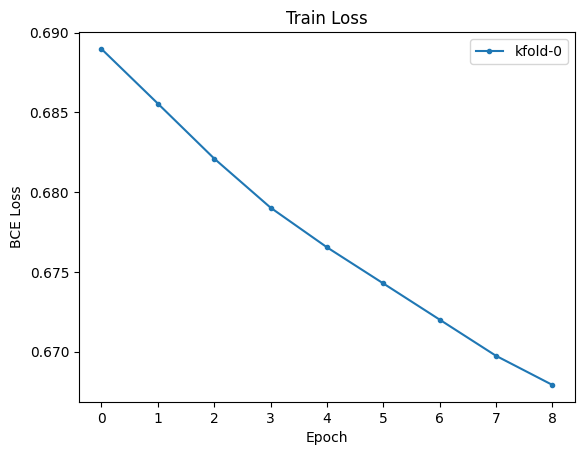

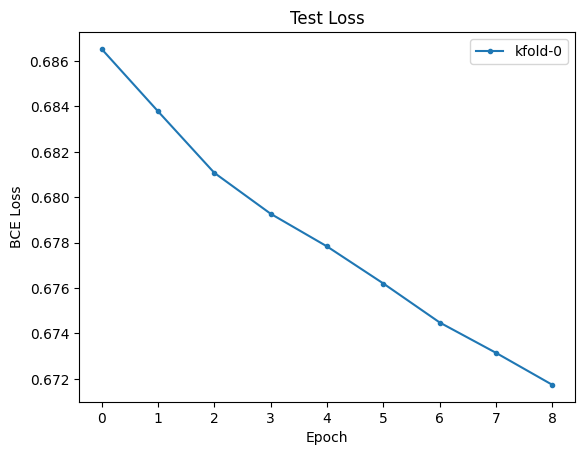

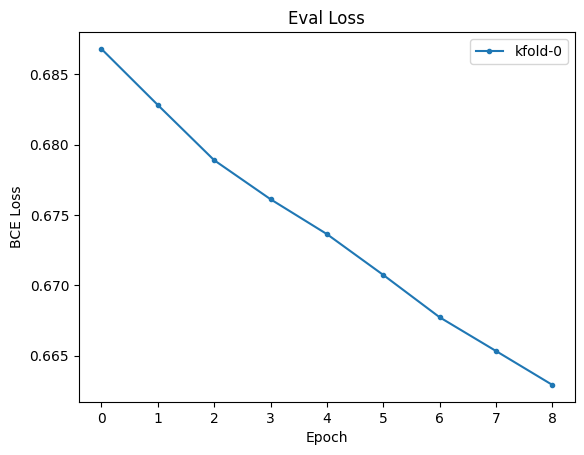

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_result(category):
    for kfold, results in data.items():
        plotting = []
        for train_record in results[category]:
            df = pd.read_csv(Path.cwd() / dir / kfold / train_record)
            plotting.append((int(str(train_record.parent).replace("Epoch ", "")), df["loss"].mean()))
        plt.plot(*zip(*sorted(plotting)), marker = ".", label = kfold)

    plt.title(f"{category.title()} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.show()

plot_result("train")
plot_result("test")
plot_result("eval")